# Calidad de Datos

### Temas:

- ¿Por qué preparar y validar los datos?
- Wrangling e imputación
- Interpolación
- Caso: Humedales
  - Scraping
  - Validación con Pydantic
- Normalización de strings:
  - Distancia de edición
  - Fuzzy string matching

## Introducción

Es conocido el hecho de que, a la hora de trabajar con datos, la mayor parte no está en tunear algorítmos ni dejar bonitas las visualizaciones, si no en la preparación de los datos.

A la hora de avanzar con cualquier tipo de análisis basado en datos, es esencial previamente asegurarnos de que estamos trabajando con datos de calidad. Si no se dedica el tiempo necesario, y si consideramos que las empresas apoyan en los datos sus decisiones de negocio, los datos faltantes o incorrectos pueden impactar directamente en la performance de las mismas. Esto se potencia aún más si la toma de decisiones se vincula a modelos de aprendizaje automático, ya que datos de entrenamiento de mala calidad resultan en aprendizajes erróneos.

No solo pueden traer complicaciones en el sistema, sino que pueden traer un impacto importante al negocio y para los usuarios (por ejemplo, [Hawaiian Airlines se disculpa después de que una falla técnica causó miles de cargos fraudulentos](https://www.hawaiinewsnow.com/2019/05/24/hawaiian-air-apologizes-after-some-customers-were-overcharged-hundreds-thousands-dollars/))

Tener datos de calidad va a proveer muchas ventajas, tales como:
- Transparencia en los procesos
- Mayor confianza en las propias decisiones de negocio
- Escalabilidad
- Ahorro de costos y tiempo

<img src='https://crunchingthedata.com/wp-content/uploads/2021/04/Case-study-one_-Data-quality-copy-2.jpg' width="700px">

La calidad puede referir a la **extensión** o a la **intención** de la data:
- En terminos de extensión:
  - Una base completa (sin nulos)
  - **Consistencia** de las categorías. Por ejemplo, si una columna tiene categorías de talles S, M o L, sería inconsistente que aparezcan talles de calzado que siguen otro criterio, del tipo numérico en este caso (talle 40, 41, etc.)
  - **Precisión** de los datos: Que no tengan errores sintácticos (por ejemplo "Ss" en vez de "S") ni semánticos (por ejemplo "M" en vez de "S").


El valor de nuestra base de datos va a depender de su **exactitud, completitud, fiabilidad y relevancia**.

In [1]:
import pandas as pd
import numpy as np

## Ejemplos de datos ruidosos

Cargamos nuestro csv: `movies.csv`

Chequeando la calidad de nuestros datos:

In [2]:
df = pd.read_csv("https://storage.googleapis.com/humai-datasets/datasets/movies.csv")

In [3]:
df.head()

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.1,\nA woman with a mysterious illness is forced ...,\n Director:\nPeter Thorwarth\n| \n Star...,"21,062",121.0,NaN
1,Masters of the Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...","17,870",25.0,NaN
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,"\n \n Stars:\nAndrew Lincoln, \n...","885,805",44.0,NaN
3,Rick and Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.2,\nAn animated series that follows the exploits...,"\n \n Stars:\nJustin Roiland, \n...","414,849",23.0,NaN
4,Army of Thieves,(2021),"\nAction, Crime, Horror",NaN,"\nA prequel, set before the events of Army of ...",\n Director:\nMatthias Schweighöfer\n| \n ...,NaN,NaN,NaN


In [4]:
# una primera inconsistencia observada son los nombres de las columnas las cuales estan algunas en mayus y otras en min
# podriamos uniformizarlas:
# df.columns = [c.lower() for c in df.columns]

## 1- Chequeamos que los tipos de datos asociados a cada columna sean los que corresponden con los que queremos.

In [5]:
df.dtypes

,0
MOVIES,object
YEAR,object
GENRE,object
RATING,float64
ONE-LINE,object
STARS,object
VOTES,object
RunTime,float64
Gross,object


Querríamos que la columna **year** sea numérica y asociada a un año. Vemos que es un objeto, para convertirlo en entero tendríamos que eliminar todos los strings o seleccionar solo la parte numérica de todas las filas.

En estos casos tan singulares vamos a usar **REGEX** (Regular Expressions). Esto refiere a secuencias de caracteres que conforman un patrón de búsquedas.

Una página útil para interpretar Regex: https://regexr.com/

In [6]:
# Por defecto nos trae la primera captura que tenga 1 o más cifras. Como tenemos algunas series de televisión (año de comienzo y año de fin), en esos casos vamos a tomar el año de inicio.

df['YEAR']=df['YEAR'].str.extract('(\d+)')
df['YEAR']

,YEAR
0,2021
1,2021
2,2010
3,2013
4,2021
...,...
9994,2021
9995,2021
9996,2022
9997,2021


Como la extracción solo trae el año tipo string, tenemos que transformarla en variable numérica.

In [7]:
df["YEAR"] = pd.to_numeric(df["YEAR"], errors='coerce')
df['YEAR'] = df['YEAR'].dropna().astype(dtype='Int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MOVIES    9999 non-null   object 
 1   YEAR      9251 non-null   Int64  
 2   GENRE     9919 non-null   object 
 3   RATING    8179 non-null   float64
 4   ONE-LINE  9999 non-null   object 
 5   STARS     9999 non-null   object 
 6   VOTES     8179 non-null   object 
 7   RunTime   7041 non-null   float64
 8   Gross     460 non-null    object 
dtypes: Int64(1), float64(2), object(6)
memory usage: 712.9+ KB


La diferencia entre `Int64` y `int64` en Pandas está relacionada con cómo manejan los datos nulos (`NaN`).

1. **`int64`**:
   - Es un tipo de datos de NumPy que representa enteros de 64 bits.
   - No puede manejar valores nulos. Si intentas asignar un `NaN` a una columna de tipo `int64`, obtendrás un error.

2. **`Int64`** (con mayúscula):
   - Es un tipo de datos de Pandas que es parte de la extensión de tipos de datos.
   - Puede manejar valores nulos, ya que utiliza un formato especial para representar `NaN`.
   - Permite trabajar con enteros y a la vez manejar valores faltantes sin problemas.

En resumen, usa `Int64` cuando necesites trabajar con enteros que pueden incluir valores nulos, y `int64` cuando estés seguro de que no habrá valores nulos y quieras optimizar el uso de memoria.

In [8]:
df["YEAR"]

,YEAR
0,2021
1,2021
2,2010
3,2013
4,2021
...,...
9994,2021
9995,2021
9996,2022
9997,2021


A las columna **VOTES** y **Gross** también la querríamos en tipo numérico para poder realizar operaciones.

¿Cómo haríamos para transformar esto?

In [9]:
df["VOTES"]=df["VOTES"].str.replace(",","")

In [10]:
df["VOTES"] = pd.to_numeric(df["VOTES"]).astype("Int64")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MOVIES    9999 non-null   object 
 1   YEAR      9251 non-null   Int64  
 2   GENRE     9919 non-null   object 
 3   RATING    8179 non-null   float64
 4   ONE-LINE  9999 non-null   object 
 5   STARS     9999 non-null   object 
 6   VOTES     8179 non-null   Int64  
 7   RunTime   7041 non-null   float64
 8   Gross     460 non-null    object 
dtypes: Int64(2), float64(2), object(5)
memory usage: 722.7+ KB


In [12]:
# Observamos los valores de la columna Gross

df["Gross"][df["Gross"].notna()]

,Gross
77,$75.47M
85,$402.45M
95,$89.22M
111,$315.54M
125,$57.01M
...,...
5750,$0.09M
5770,$0.00M
5835,$0.01M
6056,$0.01M


In [13]:
df["Gross"]=df["Gross"].str.replace("$","",  regex=False)
df["Gross"]=df["Gross"].str.replace("M","", regex=False)

In [14]:
df["Gross"] = pd.to_numeric(df["Gross"])

In [15]:
df.dtypes

,0
MOVIES,object
YEAR,Int64
GENRE,object
RATING,float64
ONE-LINE,object
STARS,object
VOTES,Int64
RunTime,float64
Gross,float64


In [16]:
df.describe()

,YEAR,RATING,VOTES,RunTime,Gross
count,9251.0,8179.000000,8179.0,7041.000000,460.000000
mean,2016.243974,6.921176,15124.062722,68.688539,43.701870
std,7.299851,1.220232,70054.5777,47.258056,82.423304
min,1932.0,1.100000,5.0,1.000000,0.000000
25%,2015.0,6.200000,166.0,36.000000,0.150000
50%,2018.0,7.100000,789.0,60.000000,6.145000
75%,2020.0,7.800000,3772.0,95.000000,46.947500
max,2023.0,9.900000,1713028.0,853.000000,504.010000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MOVIES    9999 non-null   object 
 1   YEAR      9251 non-null   Int64  
 2   GENRE     9919 non-null   object 
 3   RATING    8179 non-null   float64
 4   ONE-LINE  9999 non-null   object 
 5   STARS     9999 non-null   object 
 6   VOTES     8179 non-null   Int64  
 7   RunTime   7041 non-null   float64
 8   Gross     460 non-null    float64
dtypes: Int64(2), float64(3), object(4)
memory usage: 722.7+ KB


## 2 - Tratamiento de los nulos

Los tipos de faltantes se pueden describir de la siguiente manera:

- Cuando no existe una relación sistemática entre los valores faltantes de una columna y otros valores o valores propios. Si la probabilidad de que falten es la misma para todos los casos, se dice que **los datos faltan completamente al azar (MCAR)**. Esto implica efectivamente que las causas de los datos que faltan no están relacionadas con los datos.

- Si la probabilidad de que falten es la misma solo dentro de los grupos definidos por los datos observados, entonces **los datos faltan al azar (MAR)**. MAR es una clase mucho más amplia que MCAR. Por ejemplo, cuando se coloca sobre una superficie blanda, una balanza puede producir más valores faltantes que cuando se coloca sobre una superficie dura. Por lo tanto, tales datos no son MCAR. Sin embargo, si conocemos el tipo de superficie y podemos suponer MCAR dentro del tipo de superficie, entonces los datos son MAR.

- Si ni MCAR ni MAR se cumplen, entonces hablamos de **datos perdidos no al azar (MNAR)**. MNAR significa que la probabilidad de que falte varía por razones que desconocemos. Por ejemplo, una encuesta de opinión pública en la que aquellos con opiniones más débiles responden con menos frecuencia. Son casos problemáticos porque los valores faltantes dependen de valores no observados.

### Imputaciones posibles

Al trabajar con un conjunto de datos que tienen valores nulos, podemos tomar varias decisiones. Una es eliminar esos datos y quedarnos con las filas que tengan datos para realizar un análisis en particular. Otra de las opciones, cuando no tenemos forma de acceder al dato que nos falta, es realizar imputaciones para poder usarlos en un posterior análisis.

Scikit-learn nos ofrece varias clases con las que se pueden realizar imputaciones de valores nulos en Python. Estas usan estadísticos tales como la media, la mediana o la moda. También existen otras opciones sustentadas en algoritmos más avanzados como los k-vecinos (ver KNN-Imputer)


In [18]:
# Creamos el siguiente data que contiene valores nulos.

data = pd.DataFrame({'id': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                     'area': [1, 2, 3, 1, 2, 3, 1, 2, 3],
                     'age': [32, 30, np.nan, 23, 27, 44, 67, 23, np.nan],
                     'amount': [102, 121, 343, np.nan, 121, np.nan, 155, 149, 221]})

In [19]:
data

,id,area,age,amount
0,1,1,32.0,102.0
1,2,2,30.0,121.0
2,3,3,NaN,343.0
3,4,1,23.0,NaN
4,5,2,27.0,121.0
5,6,3,44.0,NaN
6,7,1,67.0,155.0
7,8,2,23.0,149.0
8,9,3,NaN,221.0


#### SimpleImputer

[SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) nos permite imputar un mismo valor a todos los registros nulos de una columna. Podemos usar la media, la mediana o la moda, o un valor constante que se indique.

El método de cálculo se indica con la propiedad *strategy* que puede recibir como valor: mean, median, most_frequent o constant. En el caso de que el valor sea constant es necesario indicar mediante la propiedad fill_value.

In [20]:
from sklearn.impute import SimpleImputer
simple = SimpleImputer().fit(data)
mean = simple.transform(data)

In [21]:
# Como mean es un array, lo tenemos que asociar a un DataFrame. Además, con round(1) redondeamos el valor a un decimal.

data_media = pd.DataFrame(mean,columns=data.columns).round(1)

In [22]:
data_media

,id,area,age,amount
0,1.0,1.0,32.0,102.0
1,2.0,2.0,30.0,121.0
2,3.0,3.0,35.1,343.0
3,4.0,1.0,23.0,173.1
4,5.0,2.0,27.0,121.0
5,6.0,3.0,44.0,173.1
6,7.0,1.0,67.0,155.0
7,8.0,2.0,23.0,149.0
8,9.0,3.0,35.1,221.0


Nos imputa el valor de la edad promedio (35,1) y el monto promedio (173,1).

En este caso, podríamos querer obtener números enteros, sin decimales, como en el resto de los registros, y podríamos usar la moda.

In [23]:
simple = SimpleImputer(strategy='most_frequent')
mode = simple.fit_transform(data)

In [24]:
data_moda = pd.DataFrame(mode,columns=data.columns)

In [25]:
data_moda

,id,area,age,amount
0,1.0,1.0,32.0,102.0
1,2.0,2.0,30.0,121.0
2,3.0,3.0,23.0,343.0
3,4.0,1.0,23.0,121.0
4,5.0,2.0,27.0,121.0
5,6.0,3.0,44.0,121.0
6,7.0,1.0,67.0,155.0
7,8.0,2.0,23.0,149.0
8,9.0,3.0,23.0,221.0


Ahora el valor usado en la columna age es 23, mientras que para amount es 121.

## 3 - Volviendo a nuestra base: acercamos nuestro DataFrame de películas al criterio de Tidy Data.

In [26]:
df#["STARS"]

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,2021,"\nAction, Horror, Thriller",6.1,\nA woman with a mysterious illness is forced ...,\n Director:\nPeter Thorwarth\n| \n Star...,21062,121.0,NaN
1,Masters of the Universe: Revelation,2021,"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...",17870,25.0,NaN
2,The Walking Dead,2010,"\nDrama, Horror, Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,"\n \n Stars:\nAndrew Lincoln, \n...",885805,44.0,NaN
3,Rick and Morty,2013,"\nAnimation, Adventure, Comedy",9.2,\nAn animated series that follows the exploits...,"\n \n Stars:\nJustin Roiland, \n...",414849,23.0,NaN
4,Army of Thieves,2021,"\nAction, Crime, Horror",NaN,"\nA prequel, set before the events of Army of ...",\n Director:\nMatthias Schweighöfer\n| \n ...,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9994,The Imperfects,2021,"\nAdventure, Drama, Fantasy",NaN,\nAdd a Plot\n,\n \n Stars:\nMorgan Taylor Camp...,<NA>,NaN,NaN
9995,Arcane,2021,"\nAnimation, Action, Adventure",NaN,\nAdd a Plot\n,\n,<NA>,NaN,NaN
9996,Heart of Invictus,2022,"\nDocumentary, Sport",NaN,\nAdd a Plot\n,\n Director:\nOrlando von Einsiedel\n| \n ...,<NA>,NaN,NaN
9997,The Imperfects,2021,"\nAdventure, Drama, Fantasy",NaN,\nAdd a Plot\n,\n Director:\nJovanka Vuckovic\n| \n Sta...,<NA>,NaN,NaN


In [27]:
df["Director"] = df[df["STARS"].str.contains("Director")] \
                   ["STARS"].str.split("\n",expand=True)[2]

In [28]:
df["Director"].head()

,Director
0,Peter Thorwarth
1,NaN
2,NaN
3,NaN
4,Matthias Schweighöfer


In [29]:
stars = df[df["STARS"].str.contains("Director")]\
          ["STARS"].str.split("|",expand=True)[1].str.replace("\n"," ")

In [30]:
df["Stars"] = stars.str.replace("Stars:","").str.strip()

In [31]:
df["Stars"].value_counts()

,count
Stars,
"Rorrie D. Travis, Jasmeet Baduwalia, Jacqueline Scislowski, Abraham Rodriguez",40
"Zach Tyler, Mae Whitman, Jack De Sena, Michaela Jill Murphy",34
"Aimee Carrero, Karen Fukuhara, AJ Michalka, Marcus Scribner",32
"Regina King, John Witherspoon, Cedric Yarbrough, Gary Anthony Williams",30
"Russell Curry, Hunter Deno, Kainalu Moya, Tessa Rao",25
...,...
"Dhruv Ganesh, Siddharth Menon, Shiv Panditt, Dixit",1
"Eddie Izzard, Matt LeBlanc, Udo Kier, James Cosmo",1
"Michaela Coel, Mya Lewis, Arinzé Kene, George MacKay",1


In [32]:
df.drop("STARS", axis=1, inplace=True)

In [33]:
# Limpiamos las columnas con errores sistemáticos

df["GENRE"]=df["GENRE"].str.replace("\n", "")
df["ONE-LINE"]=df["ONE-LINE"].str.replace("\n", "")

In [34]:
df.head()

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars
0,Blood Red Sky,2021,"Action, Horror, Thriller",6.1,A woman with a mysterious illness is forced in...,21062,121.0,NaN,Peter Thorwarth,"Peri Baumeister, Carl Anton Koch, Alexander ..."
1,Masters of the Universe: Revelation,2021,"Animation, Action, Adventure",5.0,The war for Eternia begins again in what may b...,17870,25.0,NaN,NaN,NaN
2,The Walking Dead,2010,"Drama, Horror, Thriller",8.2,Sheriff Deputy Rick Grimes wakes up from a com...,885805,44.0,NaN,NaN,NaN
3,Rick and Morty,2013,"Animation, Adventure, Comedy",9.2,An animated series that follows the exploits o...,414849,23.0,NaN,NaN,NaN
4,Army of Thieves,2021,"Action, Crime, Horror",NaN,"A prequel, set before the events of Army of th...",<NA>,NaN,NaN,Matthias Schweighöfer,"Matthias Schweighöfer, Nathalie Emmanuel, Ru..."


## 4 - Analizamos si los valores numéricos de las columnas son verosímiles.

In [35]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
df.describe()

,YEAR,RATING,VOTES,RunTime,Gross
count,9251,8179,8179,7041,460
mean,2016,7,15124,69,44
std,7,1,70055,47,82
min,1932,1,5,1,0
25%,2015,6,166,36,0
50%,2018,7,789,60,6
75%,2020,8,3772,95,47
max,2023,10,1713028,853,504


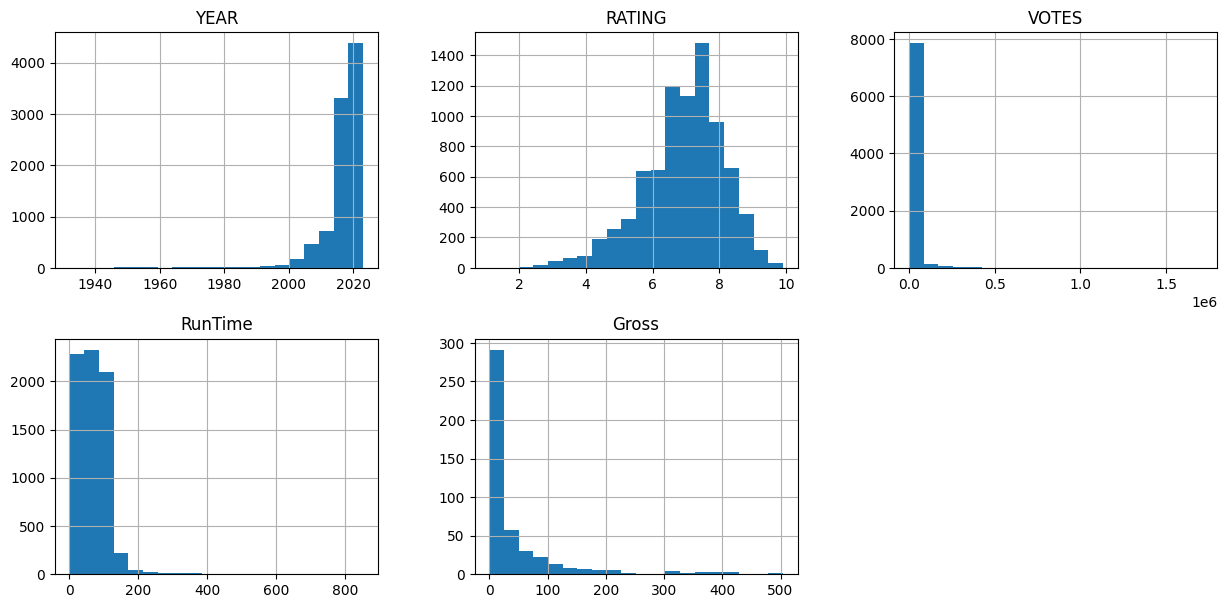

In [36]:
df.hist(
    figsize=(15,15),
    layout=(4,3),
    bins=20
    );

## 5 - ¿Hay datos duplicados?

*   **duplicated()** devuelve un booleano identificando los casos
*   **drop_duplicates()** devuelve el DataFrame sin los casos duplicados


In [37]:
df[df.duplicated()]

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars
6833,Mighty Little Bheem,2019,"Animation, Short, Adventure",NaN,Add a Plot,<NA>,NaN,NaN,"Rajiv Chilaka,",None
6835,Mighty Little Bheem,2019,"Animation, Short, Adventure",9,Add a Plot,6,NaN,NaN,"Rajiv Chilaka,",None
6836,Mighty Little Bheem,2019,"Animation, Short, Adventure",9,Add a Plot,6,NaN,NaN,"Rajiv Chilaka,",None
6837,Mighty Little Bheem,2019,"Animation, Short, Adventure",NaN,Add a Plot,<NA>,NaN,NaN,"Rajiv Chilaka,",None
6838,Mighty Little Bheem,2019,"Animation, Short, Adventure",NaN,Add a Plot,<NA>,NaN,NaN,"Rajiv Chilaka,",None
...,...,...,...,...,...,...,...,...,...,...
9989,1899,2022,"Drama, History, Horror",NaN,Add a Plot,<NA>,NaN,NaN,Baran bo Odar,None
9990,1899,2022,"Drama, History, Horror",NaN,Add a Plot,<NA>,NaN,NaN,Baran bo Odar,None
9991,1899,2022,"Drama, History, Horror",NaN,Add a Plot,<NA>,NaN,NaN,Baran bo Odar,None
9992,1899,2022,"Drama, History, Horror",NaN,Add a Plot,<NA>,NaN,NaN,Baran bo Odar,None


Vemos que hay muchos duplicados, pero que algunas filas tienen información que otras no. Queremos eliminar los duplicados y además quedarnos con las que tengan valores en rating en vez de las de nulos.

In [38]:
# pd.set_option('display.max_rows', None)

In [39]:
# Creamos una columna que mire si RATING tiene valores o no
df["tiene_rating"] = df["RATING"].to_frame().count(axis=1)

# Ordenamos alfabéticamente (por defecto, ascendentemente) según nombres de películas y la columna nueva
df = df.sort_values(['MOVIES', 'tiene_rating'])

# Borramos las películas que estén más de una vez y nos quedamos con el último valor (que es donde nos aseguramos que tiene_rating=1 en el caso de que suceda)
df = df.drop_duplicates('MOVIES', keep='last')

In [40]:
# Corroboramos y no hay más duplicados

df[df.duplicated()]

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars,tiene_rating


In [41]:
df.head()

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars,tiene_rating
8396,13 Reasons Why,2017,"Drama, Mystery, Thriller",8,"Strengthened by the struggles they've endured,...",2312,98,NaN,Brian Yorkey,"Dylan Minnette, Grace Saif, Christian Navarr...",1
9992,1899,2022,"Drama, History, Horror",NaN,Add a Plot,<NA>,NaN,NaN,Baran bo Odar,None,0
9434,3Below: Tales of Arcadia,2018,"Animation, Action, Adventure",8,"Trolls, humans, gnomes and aliens alike all ma...",5,1,NaN,NaN,NaN,1
9459,50M2,2021,"Comedy, Drama, Thriller",8,A gift leads Yakup to suspect Shadow's identit...,124,64,NaN,Burak Aksak,"Engin Öztürk, Kürsat Alniaçik, Cengiz Bozkur...",1
8502,7Seeds,2019,"Animation, Action, Adventure",8,Problems persist in the ship as the spreading ...,26,24,NaN,NaN,NaN,1


A la hora de tomar una decisión con respecto a los nulos de este DataFrame, deberíamos pensarlo en función de nuestro objetivo.

Ejercicios:

a) ¿Cuáles son los 5 directores mejor puntuados?

In [42]:
df.nlargest(5, "RATING") # forma 1

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars,tiene_rating
8510,Avatar: The Last Airbender,2005,"Animation, Action, Adventure",10,Aang's moment of truth arrives. Can he defeat ...,8813,92,NaN,Joaquim Dos Santos,"Zach Tyler, Mae Whitman, Jack De Sena, Mich...",1
8767,Dark,2017,"Crime, Drama, Mystery",10,Claudia reveals to Adam how everything is conn...,20230,73,NaN,Baran bo Odar,"Sebastian Rudolph, Louis Hofmann, Dietrich H...",1
8637,She-Ra and the Princesses of Power,2018,"Animation, Action, Adventure",10,Shadow Weaver and Catra attempt to reach Adora...,1434,24,NaN,"Christina Manrique,","Aimee Carrero, Karen Fukuhara, AJ Michalka, ...",1
8541,The Midnight Gospel,2020,"Animation, Adventure, Comedy",10,Clancy joins his mother on an emotional journe...,1731,36,NaN,"Pendleton Ward,","Joey Diaz, Deneen Fendig, Phil Hendrie, Ste...",1
7792,Anne,2017,"Drama, Family",10,Anne steps into the next chapter of her life.,2178,44,NaN,Amanda Tapping,"Amybeth McNulty, Geraldine James, R.H. Thoms...",1


In [43]:
dir_groups = df.groupby("Director").agg({ "MOVIES": "count", "RATING": "mean" })
dir_groups.reset_index(inplace=True)
dir_groups["Director"] = dir_groups["Director"].str.replace(",", "")
dir_groups.dropna(inplace=True)
dir_groups.sort_values(by="RATING", ascending=False, inplace=True)
dir_groups.head()

,Director,MOVIES,RATING
1375,Joaquim Dos Santos,1,10
2321,Pendleton Ward,1,10
270,Baran bo Odar,2,10
516,Christina Manrique,1,10
3035,Villads Spangsberg,1,10


b) ¿Cuáles son los 5 actores que más aparecen en la base? ¿Cuáles tienen mejores películas rankeadas?

In [44]:
df.head(2)

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars,tiene_rating
8396,13 Reasons Why,2017,"Drama, Mystery, Thriller",8,"Strengthened by the struggles they've endured,...",2312,98,NaN,Brian Yorkey,"Dylan Minnette, Grace Saif, Christian Navarr...",1
9992,1899,2022,"Drama, History, Horror",NaN,Add a Plot,<NA>,NaN,NaN,Baran bo Odar,None,0


Empecemos con los 5 actores que más aparecen en la base de datos

In [45]:
max_comas = int(df["Stars"].str.count(",").max())
max_comas

3

In [46]:
actors_list = []
for i in range(0, max_comas + 1):
  actors_list.append(f"Actor{i + 1}")

df[actors_list] = df['Stars'].str.split(",", expand=True)
df = df[df["Stars"].notna()]
df.drop("Stars", axis=1, inplace=True)
df.head()

<ipython-input-46-7335ed1ecef4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("Stars", axis=1, inplace=True)


,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,tiene_rating,Actor1,Actor2,Actor3,Actor4
8396,13 Reasons Why,2017,"Drama, Mystery, Thriller",8,"Strengthened by the struggles they've endured,...",2312,98,NaN,Brian Yorkey,1,Dylan Minnette,Grace Saif,Christian Navarro,Alisha Boe
9459,50M2,2021,"Comedy, Drama, Thriller",8,A gift leads Yakup to suspect Shadow's identit...,124,64,NaN,Burak Aksak,1,Engin Öztürk,Kürsat Alniaçik,Cengiz Bozkurt,Aybüke Pusat
8543,A Suitable Boy,2020,"Drama, Romance",6,Lata makes a surprising decision about her fut...,121,58,NaN,Mira Nair,1,Ishaan Khattar,Jeevan Singh Rawat,Aamir Bashir,Shubham Saraf
8276,After Life,2019,"Comedy, Drama",9,"Grieving over another loss, Tony asks his frie...",2245,30,NaN,Ricky Gervais,1,Ricky Gervais,Tom Basden,Tony Way,Diane Morgan
8044,Age of Samurai: Battle for Japan,2021,"Documentary, Action, Adventure",7,A dying Hideyoshi appoints five regents to gov...,138,44,NaN,Stephen Scott,1,Hiro Kanagawa,Hayate Masao,Hideaki Itô,Yohei Matsukado


In [47]:
value_vars = ['Actor1', 'Actor2', 'Actor3', 'Actor4']
df2 = df.melt(id_vars=df.columns.difference(value_vars), value_vars=value_vars, var_name='Actor_nro', value_name='Actor')
df2.drop(axis=1, columns="Actor_nro", inplace=True)
df2.head()

,Director,GENRE,Gross,MOVIES,ONE-LINE,RATING,RunTime,VOTES,YEAR,tiene_rating,Actor
0,Brian Yorkey,"Drama, Mystery, Thriller",NaN,13 Reasons Why,"Strengthened by the struggles they've endured,...",8,98,2312,2017,1,Dylan Minnette
1,Burak Aksak,"Comedy, Drama, Thriller",NaN,50M2,A gift leads Yakup to suspect Shadow's identit...,8,64,124,2021,1,Engin Öztürk
2,Mira Nair,"Drama, Romance",NaN,A Suitable Boy,Lata makes a surprising decision about her fut...,6,58,121,2020,1,Ishaan Khattar
3,Ricky Gervais,"Comedy, Drama",NaN,After Life,"Grieving over another loss, Tony asks his frie...",9,30,2245,2019,1,Ricky Gervais
4,Stephen Scott,"Documentary, Action, Adventure",NaN,Age of Samurai: Battle for Japan,A dying Hideyoshi appoints five regents to gov...,7,44,138,2021,1,Hiro Kanagawa


In [48]:
# Forma 1
grouped_actors = df2.groupby(by="Actor")["MOVIES"].count().reset_index()
grouped_actors["Actor"].str.strip()
grouped_actors.sort_values(by="MOVIES", ascending=False, inplace=True)
grouped_actors.head(5)

,Actor,MOVIES
9498,Jakob Eklund,17
8405,Adam Sandler,13
3644,Jens Hultén,9
9981,Liam Neeson,9
6666,Robb Wells,8


In [49]:
# Forma 2
df2["Actor"].str.strip()
df2["Actor"].value_counts().head()

,count
Actor,
Jakob Eklund,17
Adam Sandler,13
Liam Neeson,9
Jens Hultén,9
Robb Wells,8


Sigamos con los actores con películas mejor rankeadas

In [50]:
df2.head()

,Director,GENRE,Gross,MOVIES,ONE-LINE,RATING,RunTime,VOTES,YEAR,tiene_rating,Actor
0,Brian Yorkey,"Drama, Mystery, Thriller",NaN,13 Reasons Why,"Strengthened by the struggles they've endured,...",8,98,2312,2017,1,Dylan Minnette
1,Burak Aksak,"Comedy, Drama, Thriller",NaN,50M2,A gift leads Yakup to suspect Shadow's identit...,8,64,124,2021,1,Engin Öztürk
2,Mira Nair,"Drama, Romance",NaN,A Suitable Boy,Lata makes a surprising decision about her fut...,6,58,121,2020,1,Ishaan Khattar
3,Ricky Gervais,"Comedy, Drama",NaN,After Life,"Grieving over another loss, Tony asks his frie...",9,30,2245,2019,1,Ricky Gervais
4,Stephen Scott,"Documentary, Action, Adventure",NaN,Age of Samurai: Battle for Japan,A dying Hideyoshi appoints five regents to gov...,7,44,138,2021,1,Hiro Kanagawa


In [51]:
df3 = df2.groupby(by="Actor")["RATING"].mean().reset_index()
df3.sort_values(by="RATING", inplace=True, ascending=False)
df3.head()

,Actor,RATING
5546,Michaela Jill Murphy,10
11433,Zach Tyler,10
3326,Jack De Sena,10
6299,Phil Hendrie,10
4855,Louis Hofmann,10


c) ¿Cuáles son las películas de drama mejor puntuadas?

In [53]:
df_drama = df[df["GENRE"].notna() & df["GENRE"].str.contains("Drama")]
df_drama.sort_values(by="RATING", ascending=False)["MOVIES"].head()

,MOVIES
8767,Dark
7792,Anne
7870,The Dragon Prince
7641,BoJack Horseman
9080,Paranormal


## Interpolación de series de tiempo.

Veamos un ejemplo en el que queremos realizar interpolaciones para las series temporales, para así obtener nuevos puntos partiendo del conocimiento de un conjunto de puntos.

Comparemos cuatro activos: acciones, bonos, oro y petróleo.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fn = 'https://storage.googleapis.com/humai-datasets/datasets/series_ejemplo.csv'

In [60]:
prices = pd.read_csv(fn, parse_dates=['DATE'], index_col='DATE')
prices.head(2)

,SP500,Bonds,Gold,Oil
DATE,,,,
2007-06-29,1503,402,648,70
2007-07-02,1519,403,650,71


In [61]:
prices = prices.astype(int)

**`sample(frac=0.25)`**: La función sample selecciona una fracción de los elementos de la serie. frac=0.25 significa que seleccionará el 25% de los elementos de, en este caso, cada columna de forma aleatoria.

In [62]:
prices = prices.apply(lambda x: x.sample(frac=0.25))

In [63]:
prices[prices.isna().any(axis=1)]

,SP500,Bonds,Gold,Oil
DATE,,,,
2007-07-03,1524,NaN,657,NaN
2007-07-05,NaN,400,NaN,71
2007-07-06,NaN,399,NaN,NaN
2007-07-11,1518,NaN,NaN,NaN
2007-07-12,NaN,400,663,NaN
...,...,...,...,...
2017-06-13,NaN,NaN,1261,NaN
2017-06-14,NaN,620,NaN,NaN
2017-06-15,NaN,NaN,1260,44


In [64]:
prices_16 = prices[prices.index.year==2016]

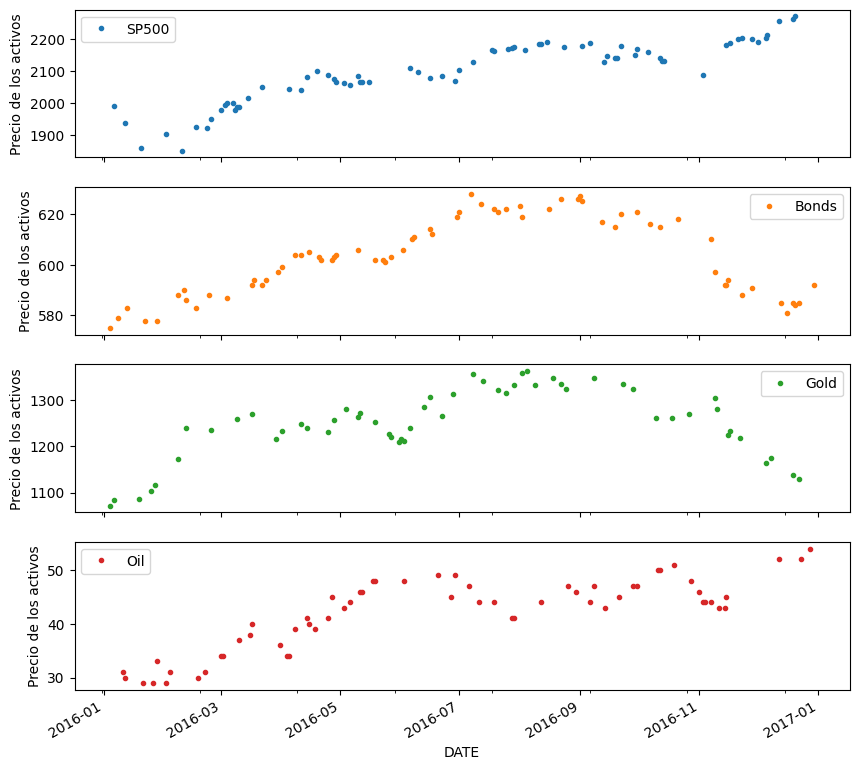

In [70]:
ejes = prices_16.plot(marker='.', linestyle='None',figsize=(10,10),subplots=True)
for eje in ejes:
    eje.set_ylabel('Precio de los activos')

Podríamos imputar los datos, es decir, unir los puntos para completar los espacios que representan NaN en nuestro datafrma, con un fillna()

In [71]:
prices_b = prices.fillna(method='bfill') # continúa el valor anterior en la serie de tiempo hasta el siguiente

<ipython-input-71-ffec86c298f8>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices_b = prices.fillna(method='bfill') # continúa el valor anterior en la serie de tiempo hasta el siguiente


<Axes: xlabel='DATE'>

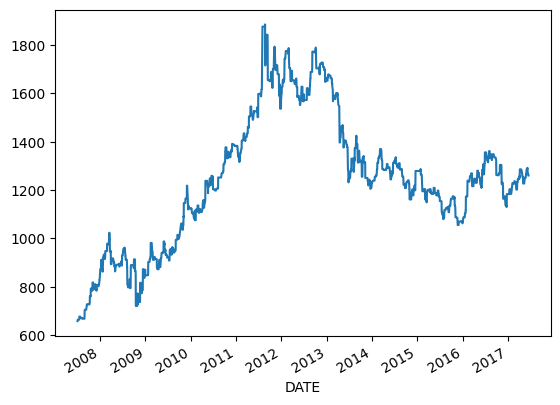

In [72]:
prices_b.Gold.plot()

In [73]:
import pandas as pd
import matplotlib.pyplot as  plt
from urllib.request import urlretrieve
plt.style.use('seaborn-v0_8')

linear = prices_16.interpolate(method='linear')
quadratic = prices_16.interpolate(method='quadratic')
nearest = prices_16.interpolate(method='nearest')

In [74]:
prices_16 = prices[prices.index.year==2016]

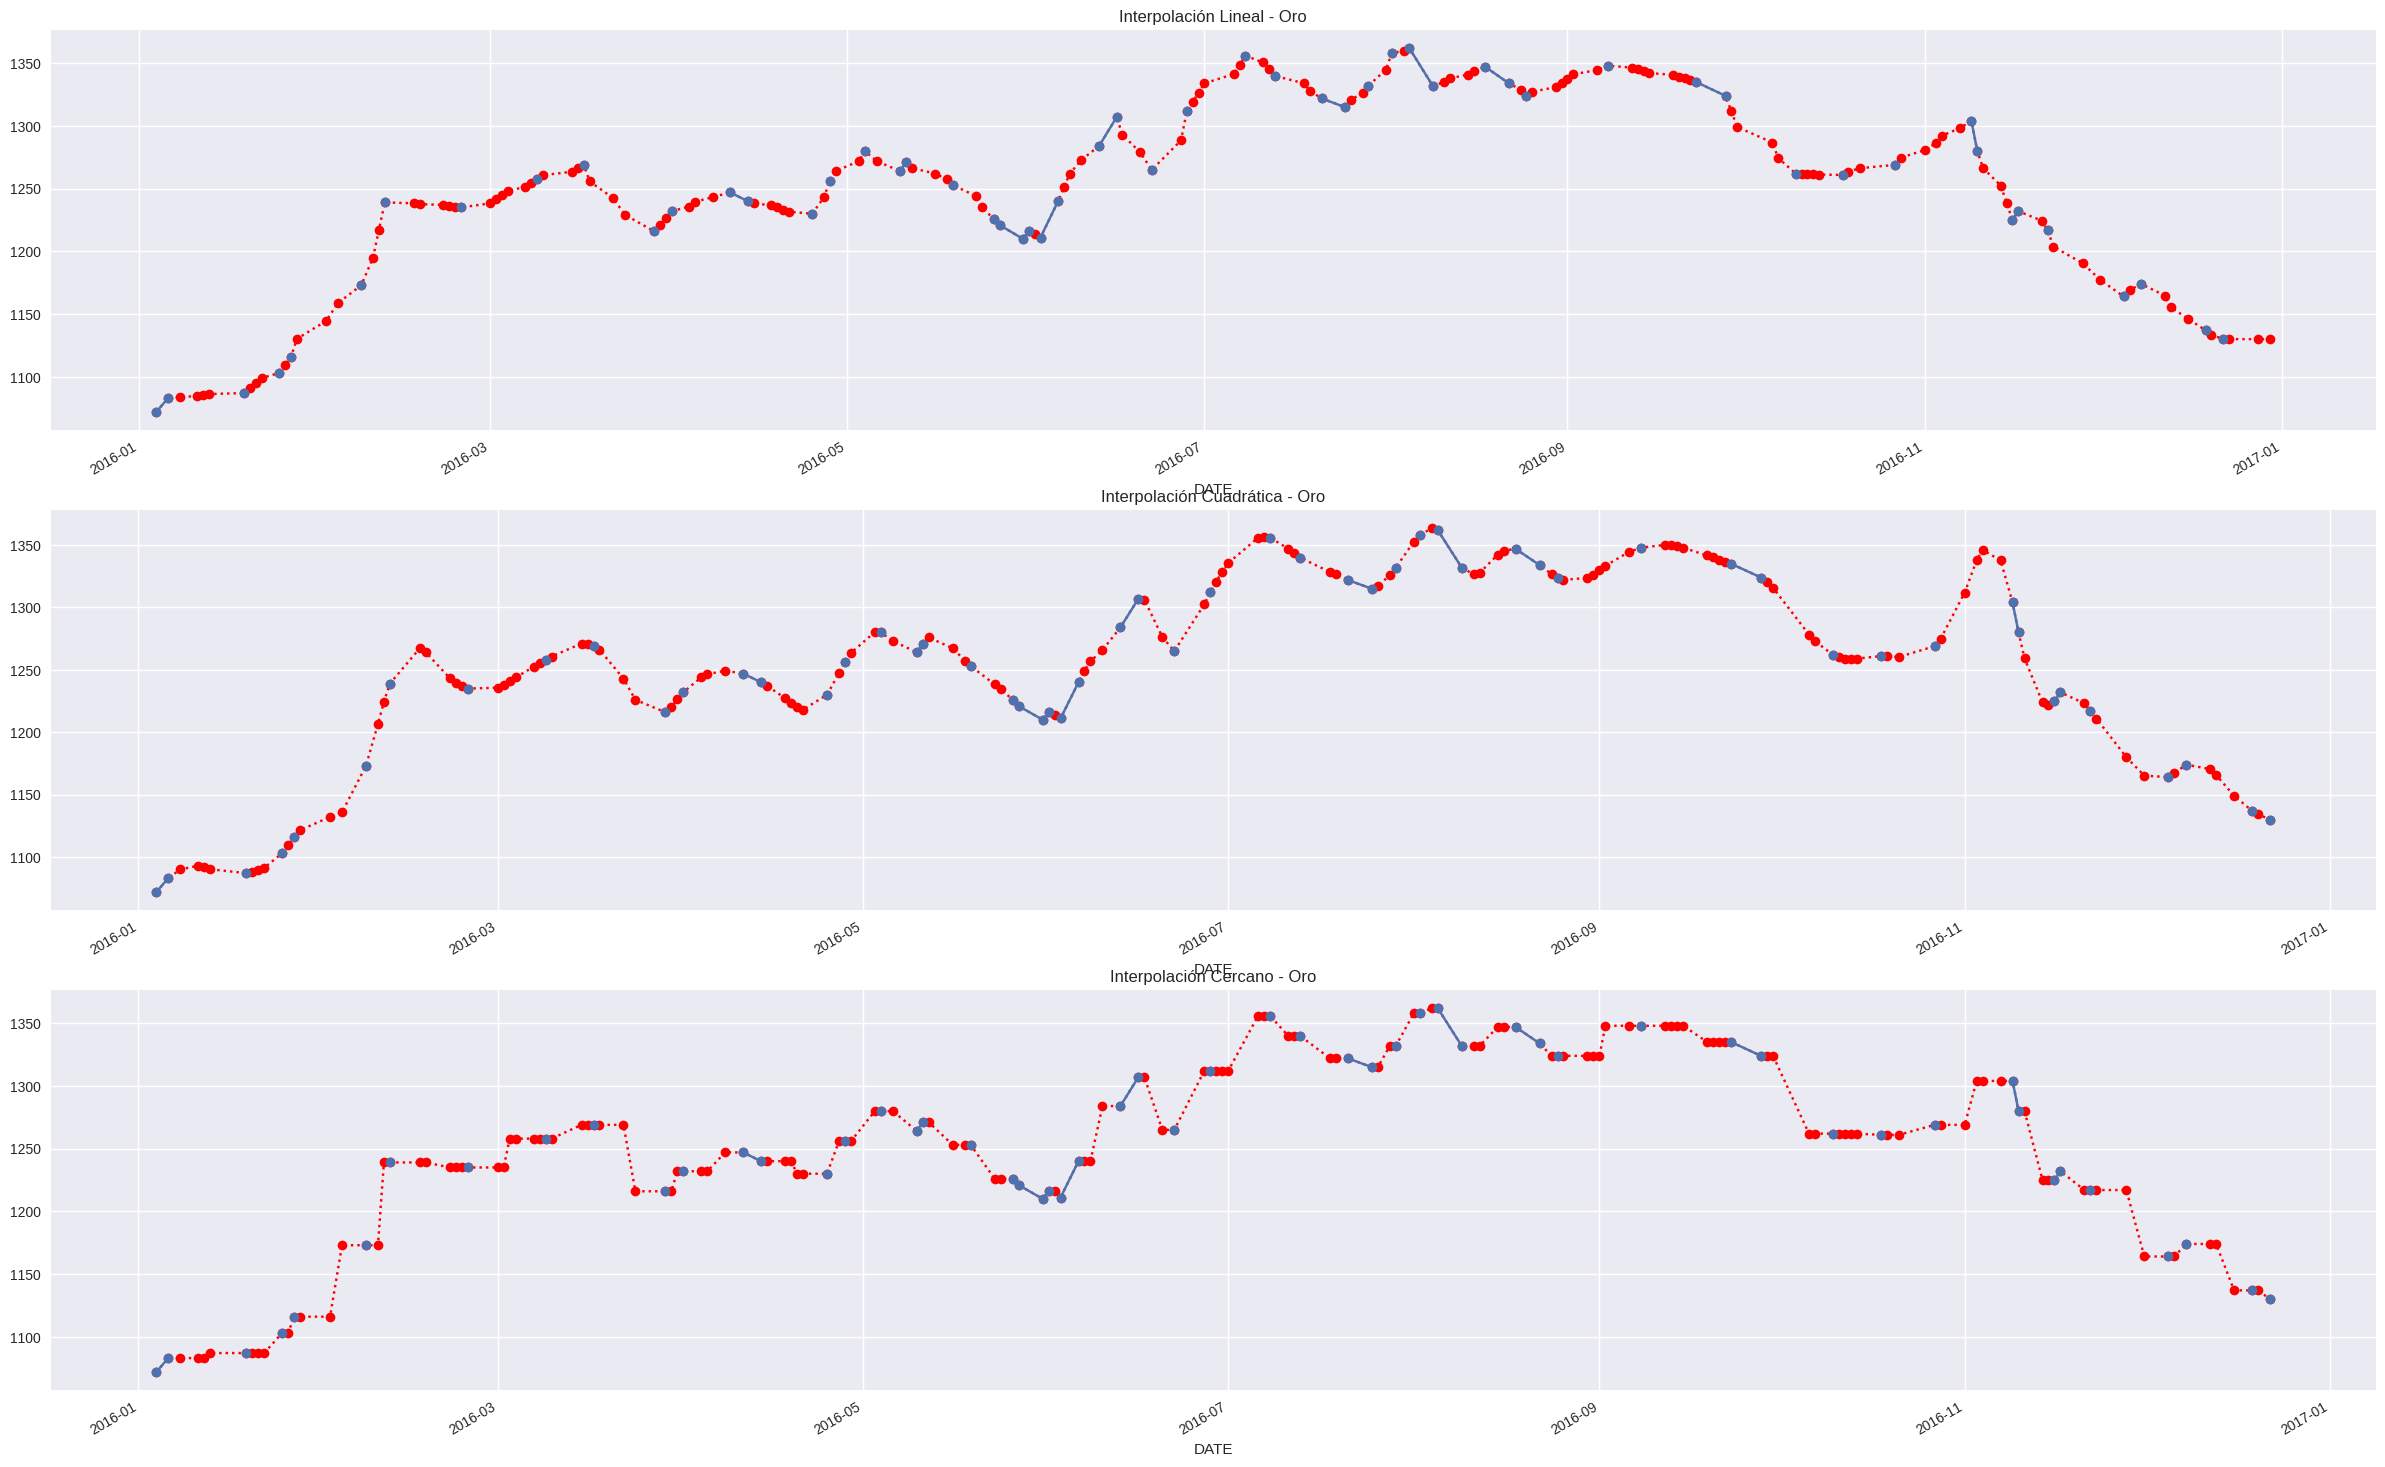

In [75]:
# Set nrows to 3 and ncols to 1
fig, axes = plt.subplots(3, 1, figsize=(30, 20))

# Create a dictionary of interpolations
interpolations = {'Interpolación Lineal': linear, 'Interpolación Cuadrática': quadratic,
                  'Interpolación Cercano': nearest}

# Loop over axes and interpolations
for ax, df_key in zip(axes, interpolations):
    # Select and also set the title for a DataFrame
    interpolations[df_key].Gold.plot(color='red', marker='o',
                                 linestyle='dotted', ax=ax)
    prices_16.Gold.plot(title=df_key + ' - Oro', marker='o', ax=ax)

plt.show()

## Ley de Humedales

## Extracción de los datos Web
Datos sobre legisladores y sus posturas frente a la Ley de Humedales.

Gracias a https://activaelcongreso.ar por la data.

Pasos para el scraping:
- Identificar el tema a investigar
- Identificar una fuente de datos (activaelcongreso.ar)
- Dentro del sitio, ver dónde se renderizan los datos:
https://activaelcongreso.ar/p/Ley_de_Humedales_Ya/politicos
- Aplicar lo que se ve en la clase de APIs Ocultas (agregar link):
  - Abrimos ChromeDevTools
  - Vamos a la pestaña Network
  - Identificamos (podemos usar el buscador) los requests que contienen la info
  - Copiamos el request como cURL, y usamos algo como https://curlconverter.com/ para convertirlo a Python
  - Identificamos la parte central del request, quitando los cookies y headers no esenciales

Con eso podemos bajar los distintos jsons que necesitamos, y unirlos para armar la tabla con datos útiles.

In [76]:
# Bajamos datos encontrados en distintos requests

import requests

json_data = {
    'type': 'TipoPolitico',
    'action': 'get',
    'params': {},
}

response = requests.post('https://activaelcongreso.ar/PHP/api.php', json=json_data)
response.json()

ConnectionError: HTTPSConnectionPool(host='activaelcongreso.ar', port=443): Max retries exceeded with url: /PHP/api.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7c1072495990>: Failed to resolve 'activaelcongreso.ar' ([Errno -2] Name or service not known)"))

## Pydantic


Cuando armamos aplicaciones con distintos componentes, es útil ir más allá del **tipado dinámico** y definir los típos de datos y **esquemas** que esperamos. Es decir, por medio de alguna utilidad, como es el caso de **pydantic** abajo, podemos crear una herramienta que nos permita valdiar un dataset en función de qué columnas esperamos, con qué formato, con qué tipo de dato, etc.

Link a documentación: https://docs.pydantic.dev/2.9/concepts/fields/#field-aliases

Definamos un primer ejemplo de juguete:

In [77]:
from typing import Optional
from pydantic import BaseModel, Field


class SuperDict(BaseModel):
    '''
    Field nos permite especificar caracteristicas del campo, como descripcion o restricciones.
    Podemos dejar campos como opcionales con Optional.
    '''
    id: int = Field(ge=1)
    nombre: str = Field(min_length=1, max_length=30)
    altura: Optional[float] = Field(ge=0, le=300, description="Altura en cm.")

In [78]:
SuperDict(id=1, nombre='Ernesto', altura=170.0)

SuperDict(id=1, nombre='Ernesto', altura=170.0)

In [79]:
caso = {"id": 2, "nombre": ""}

In [80]:
from pydantic import ValidationError

try:
    SuperDict(**caso)
except ValidationError as e:
    print(e)

2 validation errors for SuperDict
nombre
  String should have at least 1 character [type=string_too_short, input_value='', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/string_too_short
altura
  Field required [type=missing, input_value={'id': 2, 'nombre': ''}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing


In [81]:
# Info sobre los bloques
json_data = {
    'type': 'Bloque',
    'action': 'get',
    'params': {},
}

bloques = requests.post('https://activaelcongreso.ar/PHP/api.php', json=json_data).json()

ConnectionError: HTTPSConnectionPool(host='activaelcongreso.ar', port=443): Max retries exceeded with url: /PHP/api.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7c1071ceb370>: Failed to resolve 'activaelcongreso.ar' ([Errno -2] Name or service not known)"))

In [ ]:
bloques

[{'id': '4',
  'foto': 'bloque-4.jpg',
  'nombre': 'Frente de Todos',
  'color': '4fc3f7'},
 {'id': '6', 'foto': 'bloque-6.jpg', 'nombre': 'PRO', 'color': 'fdd835'},
 {'id': '7',
  'foto': 'bloque_default.jpg',
  'nombre': 'Producción y Trabajo',
  'color': '000000'},
 {'id': '9',
  'foto': 'bloque_default.jpg',
  'nombre': 'Unidad y Equidad por San Luis',
  'color': '000000'},
 {'id': '11',
  'foto': 'bloque-11.jpg',
  'nombre': 'Unión Cívica Radical',
  'color': 'b71c1c'},
 {'id': '12',
  'foto': 'bloque-12.jpg',
  'nombre': 'Partido por la Justicia Social',
  'color': '01579b'},
 {'id': '13',
  'foto': 'bloque-13.jpg',
  'nombre': 'Justicialista',
  'color': '0288d1'},
 {'id': '14',
  'foto': 'bloque-14.jpg',
  'nombre': 'Consenso Federal',
  'color': '1a237e'},
 {'id': '18',
  'foto': 'bloque-18.jpg',
  'nombre': 'Córdoba Federal',
  'color': '29b6f6'},
 {'id': '19',
  'foto': 'bloque-19.jpg',
  'nombre': 'Coalición Cívica',
  'color': '01579b'},
 {'id': '21',
  'foto': 'bloque-21.

Podemos validar el dato que esperamos con un esquema de pydantic.

### Ejemplo Bloques

In [82]:
class BloqueID(BaseModel):
    id: int
    foto: str
    nombre: str
    color: str

In [83]:
# Podemos validar todos los bloques que nos trajo la API
bloques_validados = [BloqueID(**b) for b in bloques][:5]

NameError: name 'bloques' is not defined

In [ ]:
bloques_validados[0].foto

Podemos hacer validaciones personalizadas, como validar que el campo de  `foto` termine con `jpg` usando el **decorador `validator`**

In [87]:
from pydantic import validator


class BloqueID(BaseModel):
    id: int
    foto: str
    nombre: str
    color: str

    @validator('foto')
    def validate_photo(cls, v):
        assert v.endswith('jpg'), 'No termina con JPG'
        return v

<ipython-input-87-2f7b3a75afcb>:10: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
  @validator('foto')


O validar que el campo "nombre" pertenezca a una lista de nombres predefinidos

In [84]:
from typing import List
from enum import Enum

class Bloque(Enum):
    FRENTE_DE_TODOS = 'Frente de Todos'
    PRO = 'PRO'
    PRODUCCIÓN_Y_TRABAJO = 'Producción y Trabajo'
    UNIDAD_Y_EQUIDAD_POR_SAN_LUIS = 'Unidad y Equidad por San Luis'
    UNIÓN_CÍVICA_RADICAL = 'Unión Cívica Radical'
    PARTIDO_POR_LA_JUSTICIA_SOCIAL = 'Partido por la Justicia Social'
    JUSTICIALISTA = 'Justicialista'
    CONSENSO_FEDERAL = 'Consenso Federal'
    CÓRDOBA_FEDERAL = 'Córdoba Federal'
    COALICIÓN_CÍVICA = 'Coalición Cívica'
    FRENTE_PROGRESISTA_CÍVICO_Y_SOCIAL = 'Frente Progresista Cívico y Social'
    PTS_FRENTE_DE_IZQUIERDA = 'PTS - Frente de Izquierda'
    SOCIALISTA = 'Socialista'
    JUNTOS_SOMOS_RIO_NEGRO = 'Juntos Somos Rio Negro'
    FRENTE_DE_IZQUIERDA_Y_DE_LOS_TRABAJADORES = 'Frente de Izquierda y de los Trabajadores - Unidad'
    FRENTE_DE_LA_CONCORDIA_MISIONERO = 'Frente de la Concordia Misionero'
    MOVIMIENTO_POPULAR_NEUQUINO = 'Movimiento Popular Neuquino'
    ACCION_FEDERAL = 'Acción Federal'
    FRENTE_CÍVICO_Y_SOCIAL_DE_CATAMARCA = 'Frente Cívico y Social de Catamarca'
    FUERZA_CÍVICA_RIOJANA = 'Fuerza Cívica Riojana'
    AVANZAR_SAN_LUIS = 'Avanzar San Luis'
    SANTA_FE_FEDERAL = 'Santa Fe Federal'
    JUSTICIALISTA_8_DE_OCTUBRE = 'Justicialista 8 de Octubre'
    MISIONES = 'Misiones '
    UNIDAD_FEDERAL_PARA_EL_DESARROLLO = 'Unidad Federal para el Desarrollo'
    AVANZA_LIBERTAD = 'Avanza Libertad'
    AHORA_PATRIA = 'Ahora Patria'
    IDENTIDAD_BONAERENSE_ = 'Identidad Bonaerense '
    EVOLUCIÓN_RADICAL = 'Evolución Radical'
    ENCUENTRO_FEDERAL = 'Encuentro Federal'
    CREO = 'Creo'
    IZQUIERDA_SOCIALISTA_FRENTE_DE_IZQUIERDA = 'Izquierda Socialista - Frente de Izquierda'
    LA_LIBERTAD_AVANZA = 'La Libertad Avanza'
    UNIDOS_POR_SAN_LUIS = 'Unidos por San Luis'
    PARTIDO_OBRERO_FRENTE_DE_IZQUIERDA_Y_DE_LOS_TRABAJADORES_UNIDAD = 'Partido Obrero - Frente de Izquierda y de los Trabajadores - Unidad'
    PTS_FRENTE_DE_IZQUIERDA_DE_TRABAJADORES_UNIDAD = 'PTS - Frente de Izquierda de Trabajadores - Unidad'
    REPUBLICANOS_UNIDOS_ = 'Republicanos Unidos '
    SIN_BLOQUE = 'Sin Bloque'
    SER_SOMOS_ENERGÍA_PARA_RENOVAR = 'SER - Somos Energía para Renovar'
    UNIDAD_Y_EQUIDAD_FEDERAL = 'Unidad y Equidad Federal'

### Ejemplo con Enum

In [85]:
from pydantic import validator


class BloqueID(BaseModel):
    id: int
    foto: str
    # Bloque ahora solo puede ser alguno de los valores de arriba
    nombre: Bloque
    color: str

    @validator('foto')
    def validate_photo(cls, v):
        assert v.endswith('jpg'), 'No termina con JPG'
        return v

<ipython-input-85-f89993bbbf4f>:11: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
  @validator('foto')


In [ ]:
BloqueID(**bloques[0]).nombre

<Bloque.FRENTE_DE_TODOS: 'Frente de Todos'>

In [86]:
bloque = {'id': '4',
          'foto': 'bloque-4.jpg',
          'nombre':'Frente de Algunos',
          'color': '4fc3f7'}

In [88]:
BloqueID(**bloque)

BloqueID(id=4, foto='bloque-4.jpg', nombre='Frente de Algunos', color='4fc3f7')

¿Cómo podemos hacer para normalizar y reparar casos como este? Veremos cómo hacerlo con **búsqueda difusa de strings**

### Ejercicio Pydantic

1. Crear un esquema de PyDantic que valide el siguiente JSON de `Politico`.
2. Crear otro esquema para `Sexo` que valide que el número en ese campo sea uno de los dos permitidos (0,1). Hacer que `Politico` tenga un campo `Sexo`.
3. Agregar validación para la fecha de nacimiento y para el mail (se podría pensar una validación usando REGEX para el mail)

In [ ]:
# Info de políticos
json_data = {
    'type': 'Politico',
    'action': 'get',
    'params': {},
}

politicos = requests.post('https://activaelcongreso.ar/PHP/api.php', json=json_data).json()
politicos[0]

In [ ]:
import re


class Sexo(Enum):
    MUJER = '0'
    HOMBRE = '1'


class Politico(BaseModel):
    id: int
    nombre: str
    apellido: str
    foto: str
    tipo: int
    bloque: int
    sexo: Sexo
    estado_civil: int
    fecha_nacimiento: str
    religion: int
    provincia: int
    localidad: int
    telefono: str
    telefono_interno: str
    email: str
    twitter: str
    facebook: str
    instagram: str
    eliminado: int
    activo: int

    # Validador para el campo email
    # No es un regex muy exhaustivo, pero sirve para el ejemplo.
    @validator("email")
    def check_email(cls, v):
        pattern = '.+@.+'
        assert re.match(pattern, v), 'Mail incorrecto'
        return v

    # Que pasa si nuestro json tiene campos que no se corresponden con
    # el snakecase de nuestra clase?
    # Podemos definir un mapeo así:
    class Config:
        fields = {
            'estado_civil': 'estadoCivil',
            'fecha_nacimiento': 'fechaNacimiento',
            'telefono_interno': 'telefonoInterno'
        }

In [ ]:
Politico(**politicos[0])

## Distancia de edición


Para afrontar el "ruido" en nuestros textos, tenemos una importante herramienta: la distancia de edición.

También llamada Distancia de Levenshtein, nos dice la cantidad mínima de operaciones requerida para llevar de un string al otro. Expresandola de una manera sencilla (y en su versión sin normalizar entre 0 y 1) podemos explicarla así:

$$\mathit{L} = S+D+I$$

Donde $S$ = sustitución, $D$ = Eliminación, $I$ = inserción (de un caracter).


También podemos usarla entre dos listas como métrica de similitud.

In [89]:
from nltk.metrics import edit_distance

In [94]:
# Definimos una lista de tuplas de palabras
# en este tejemplo, para llevar la palabra pero a perro nos falta una r, entonces la distancia es 1
palabras = [("pero", "perro"),("pero", "pierdo"), ("nueve", "mueve"),  ("totalmente","diferentes"), ("pero", "basta")]

for x,y in palabras:
    print(f"'{x}' vs '{y}':")
    print("Distancia Levenshtein ->", edit_distance(x,y))
    print("-"*40)

'pero' vs 'perro':
Distancia Levenshtein -> 1
----------------------------------------
'pero' vs 'pierdo':
Distancia Levenshtein -> 2
----------------------------------------
'nueve' vs 'mueve':
Distancia Levenshtein -> 1
----------------------------------------
'totalmente' vs 'diferentes':
Distancia Levenshtein -> 7
----------------------------------------
'pero' vs 'basta':
Distancia Levenshtein -> 5
----------------------------------------


## Búsqueda difusa de strings (fuzzy string matching)

Técnica muy útil para tener en el repertorio, nos permite encontrar coincidencias que no son exactas. En el caso más sencillo, la búsqueda difusa nos devolverá un puntaje de similitud entre los strings relacionada a las diferencias entre los caracteres. Existen variaciones que consideran cuántas unidades (palabras, tokens) coinciden, que ordenan la oración antes, o que borran repetidos.

Hay distintas alternativas, que pueden separar en palabras, ordenarlas, borrar duplicadas, o calcular la superposicion del string directamente. Pueden ver todas las disponibles en: https://github.com/seatgeek/thefuzz

In [90]:
%%capture
!pip install thefuzz[speedup]
from thefuzz import process, fuzz

In [91]:
c1 = 'uno dos tres'
c2 = 'uno doce trece'
fuzz.ratio(c1, c2) # entre 0 y 100

77

Podemos usar esta función para encontrar la mejor coincidencia para una palabra en una lista de candidatos:

In [92]:
def get_match(string, lista_strings):
    """Para buscar coincidencias entre nombre con los nombres"""
    mejor_match, puntaje = process.extractBests(string.strip(), lista_strings, scorer=fuzz.ratio)[0]
    return mejor_match, puntaje

In [93]:
bloques

NameError: name 'bloques' is not defined

In [ ]:
nombres_bloques = [b["nombre"] for b in bloques]

In [ ]:
nombres_bloques

['Frente de Todos',
 'PRO',
 'Producción y Trabajo',
 'Unidad y Equidad por San Luis',
 'Unión Cívica Radical',
 'Partido por la Justicia Social',
 'Justicialista',
 'Consenso Federal',
 'Córdoba Federal',
 'Coalición Cívica',
 'Frente Progresista Cívico y Social',
 'PTS - Frente de Izquierda',
 'Socialista',
 'Juntos Somos Rio Negro',
 'Frente de Izquierda y de los Trabajadores - Unidad',
 'Frente de la Concordia Misionero',
 'Movimiento Popular Neuquino',
 'Acción Federal',
 'Frente Cívico y Social de Catamarca',
 'Fuerza Cívica Riojana',
 'Avanzar San Luis',
 'Santa Fe Federal',
 'Justicialista 8 de Octubre',
 'Misiones ',
 'Unidad Federal para el Desarrollo',
 'Avanza Libertad',
 'Ahora Patria',
 'Identidad Bonaerense ',
 'Evolución Radical',
 'Encuentro Federal',
 'Creo',
 'Izquierda Socialista - Frente de Izquierda',
 'La Libertad Avanza',
 'Unidos por San Luis',
 'Partido Obrero - Frente de Izquierda y de los Trabajadores - Unidad',
 'PTS - Frente de Izquierda de Trabajadores - 

In [ ]:
busqueda = 'Frente de Algunos'
get_match(busqueda, nombres_bloques)

('Frente de Todos', 75)